In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)

data = pd.read_csv("Phishing_Legitimate_full.csv")
data.rename(columns={'CLASS_LABEL': 'labels'}, inplace=True)
X = data.drop(['id', 'labels'], axis=1)
y = data['labels']

discrete_features = X.dtypes == int
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

top_n_features = mi_scores.head(32).index.tolist()
X = data[top_n_features]
y = data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

log_reg = LogisticRegression(max_iter=10000)
svc_clf = SVC(probability=True)
dt_clf = DecisionTreeClassifier(max_depth=32)

adaboost_clf = AdaBoostClassifier(base_estimator=log_reg, n_estimators=50)
adaboost_clf.fit(X_train, y_train)

y_pred_adaboost = adaboost_clf.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
precision_adaboost = precision_score(y_test, y_pred_adaboost)
recall_adaboost = recall_score(y_test, y_pred_adaboost)
f1_adaboost = f1_score(y_test, y_pred_adaboost)
report_adaboost = classification_report(y_test, y_pred_adaboost)

print("AdaBoost Classifier Results:")
print(f'Accuracy: {accuracy_adaboost}')
print(f'Precision: {precision_adaboost}')
print(f'Recall: {recall_adaboost}')
print(f'F1 Score: {f1_adaboost}')
print(f'Classification Report:\n{report_adaboost}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost Classifier Results:
Accuracy: 0.9135
Precision: 0.9149357072205737
Recall: 0.9140316205533597
F1 Score: 0.9144834404349976
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       988
           1       0.91      0.91      0.91      1012

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



  0%|          | 0/100 [00:00<?, ?it/s]

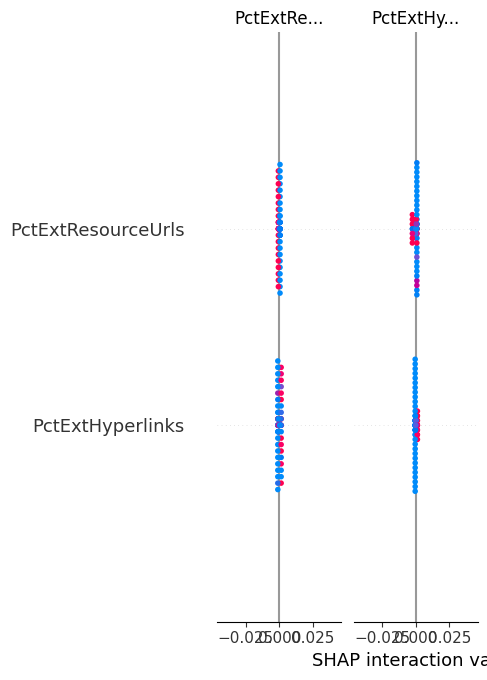

In [ ]:
shap.initjs()
X_test1=X_test.head(100)
# Reduce the background data to 10 samples
background = shap.sample(X_train, 100)

# Initialize SHAP Explainer with the reduced background data
explainer = shap.KernelExplainer(adaboost_clf.predict_proba, background)

# Calculate SHAP values for the test set
shap_values = explainer(X_test1)

# Plot SHAP values
shap.summary_plot(shap_values, X_test1, feature_names=X.columns) # Pass feature names as keyword argument

In [ ]:
# LIME
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=top_n_features, class_names=['Legitimate', 'Phishing'], discretize_continuous=True)

exp = lime_explainer.explain_instance(X_test.iloc[0], adaboost_clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


[('QueryLength <= 0.00', -0.018481874188495576), ('NumDash > 2.00', -0.011551435337321083), ('FrequentDomainNameMismatch <= 0.00', -0.010254828944043445), ('NumQueryComponents <= 0.00', 0.009263773402376819), ('SubmitInfoToEmail <= 0.00', 0.008326984786221207), ('HostnameLength <= 14.00', -0.00822810366693571), ('NumDashInHostname <= 0.00', -0.007840599470459191), ('48.00 < UrlLength <= 62.00', 0.006216033247278295), ('IframeOrFrame <= 0.00', 0.005980011708870051), ('-1.00 < PctExtNullSelfRedirectHyperlinksRT <= 1.00', -0.005883207271117335)]


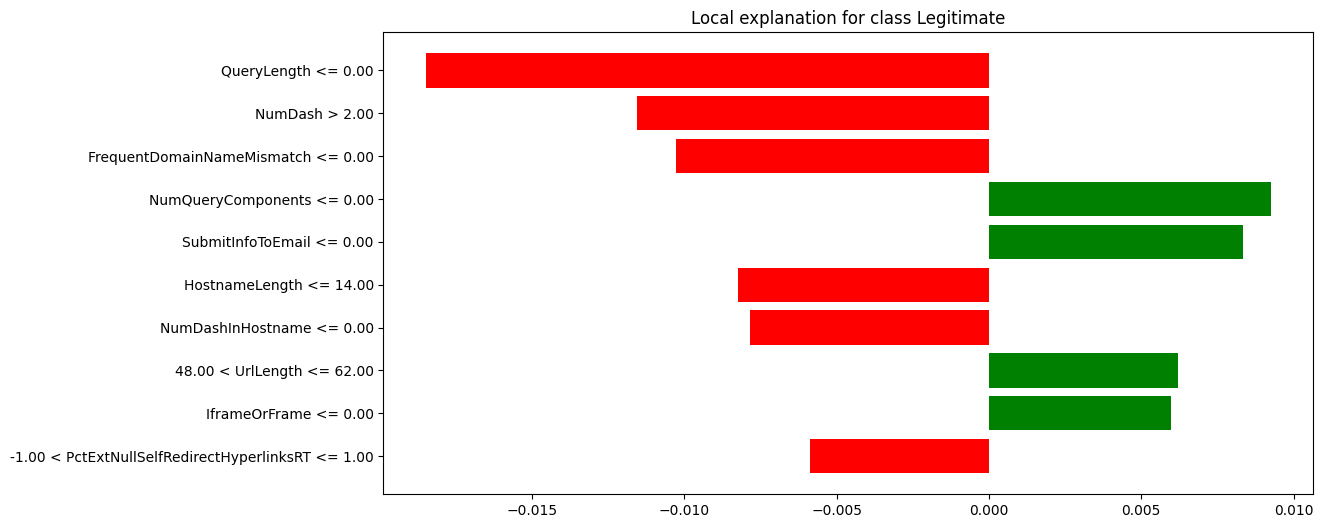

In [ ]:
# ELI5 XAI implementation using LIME
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['Phishing', 'Legitimate'], discretize_continuous=True)
exp = explainer.explain_instance(X_test.values[0], adaboost_clf.predict_proba, num_features=10)

# Print the ELI5 explanation
print(exp.as_list())

# Plot the ELI5 explanation
exp.as_pyplot_figure().show()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


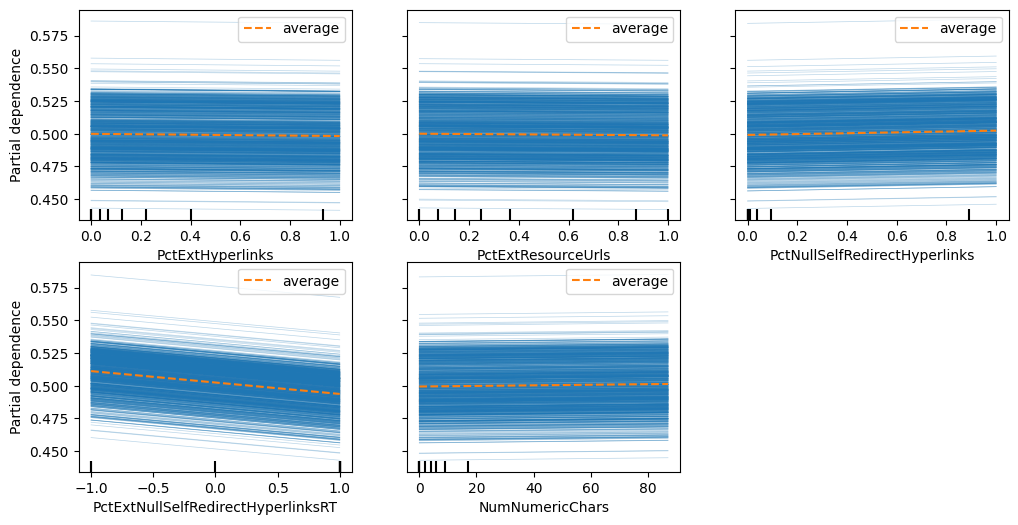

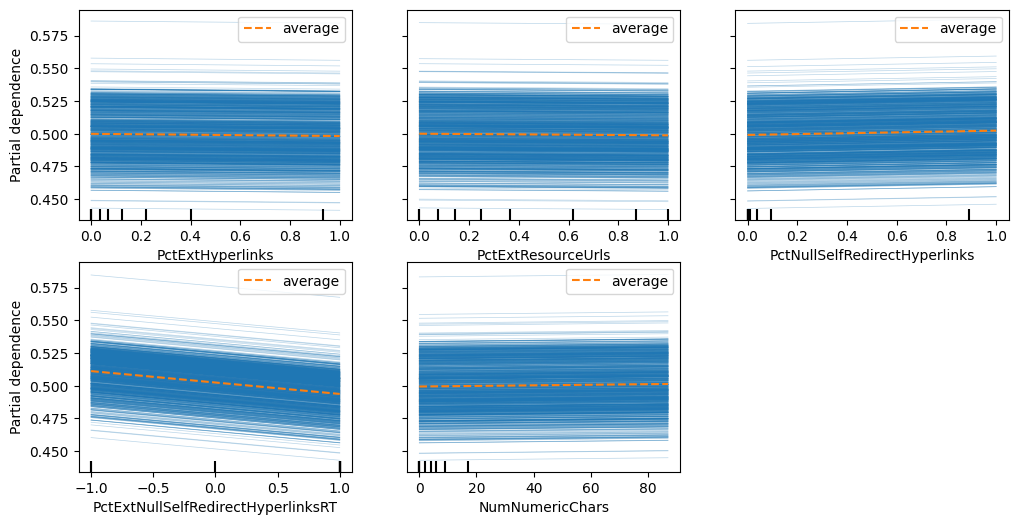

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Select the top 5 most important features
top_features = mi_scores.head(5).index.tolist()

# Fit the AdaBoost classifier (you already have this part)
adaboost_clf.fit(X_train, y_train)

# Create a PartialDependenceDisplay object
pdp_display = PartialDependenceDisplay.from_estimator(
    adaboost_clf, X_train.sample(1000, random_state=42), features=top_features, kind="both"
)

# Plot the partial dependence plots
fig, ax = plt.subplots(figsize=(12, 6))
pdp_display.plot(ax=ax)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


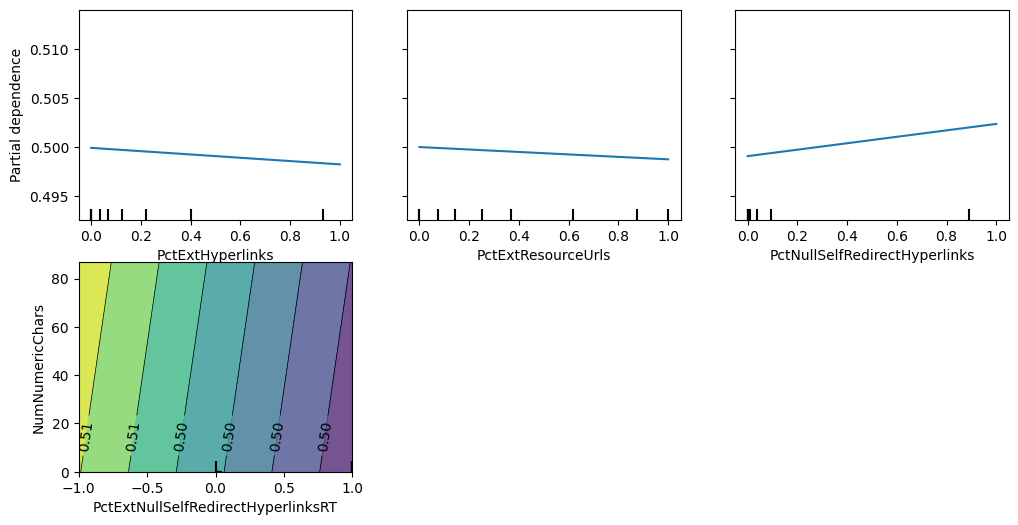

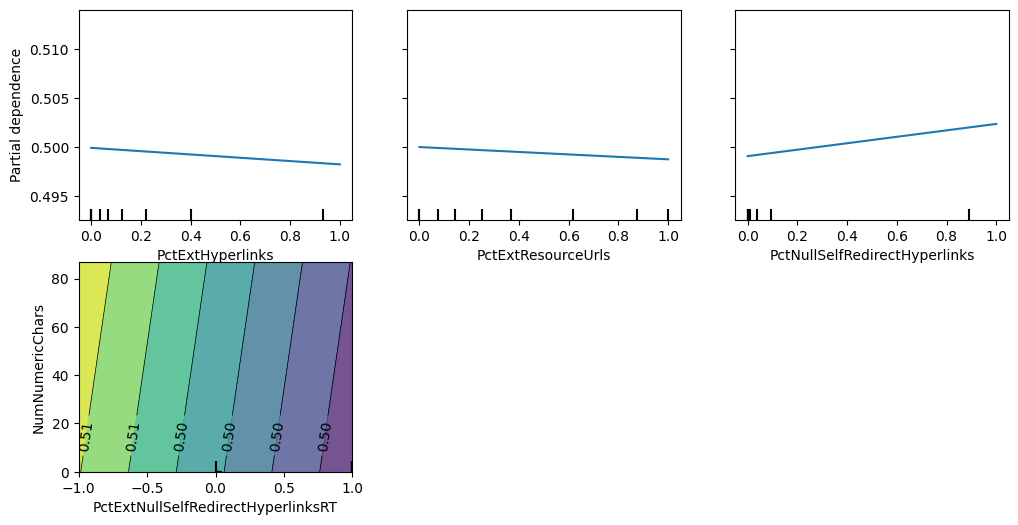

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Select the top 3 most important features for single plots and 2 for interaction plot
top_features = mi_scores.head(5).index.tolist()

# Fit the AdaBoost classifier (you already have this part)
adaboost_clf.fit(X_train, y_train)

# Create and plot PartialDependenceDisplay with both single-feature and two-feature interaction
pdp_display = PartialDependenceDisplay.from_estimator(
    adaboost_clf,
    X_train.sample(1000, random_state=42),
    features=[top_features[0], top_features[1], top_features[2], (top_features[3], top_features[4])],
    kind="average"
)

# Display the plots in a grid similar to the example
pdp_display.plot()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


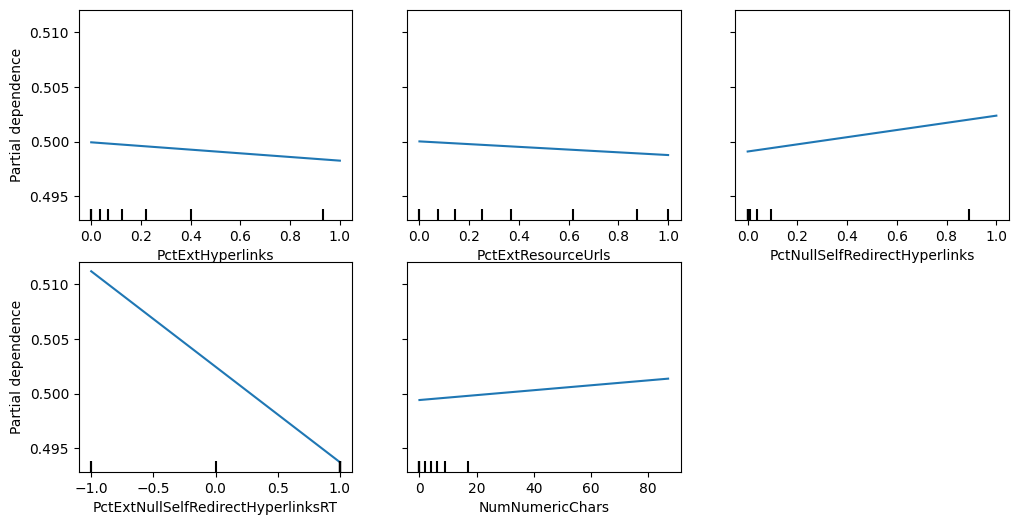

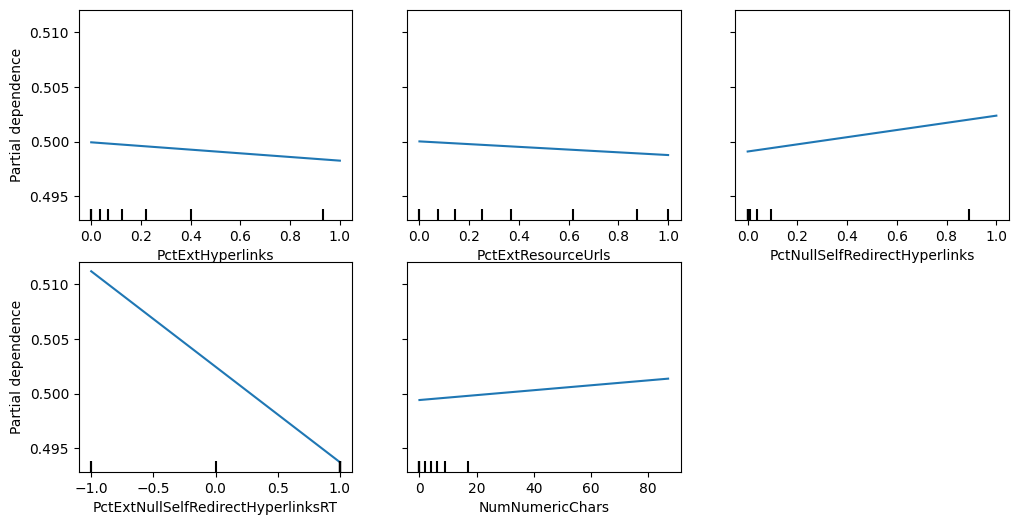

In [ ]:

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Select the top 5 most important features
top_features = mi_scores.head(5).index.tolist()

# Fit the AdaBoost classifier (you already have this part)
adaboost_clf.fit(X_train, y_train)

# Create and plot PartialDependenceDisplay with simpler "average" plots
pdp_display = PartialDependenceDisplay.from_estimator(
    adaboost_clf, X_train.sample(1000, random_state=42), features=top_features, kind="average"
)

# Display the plots
pdp_display.plot()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


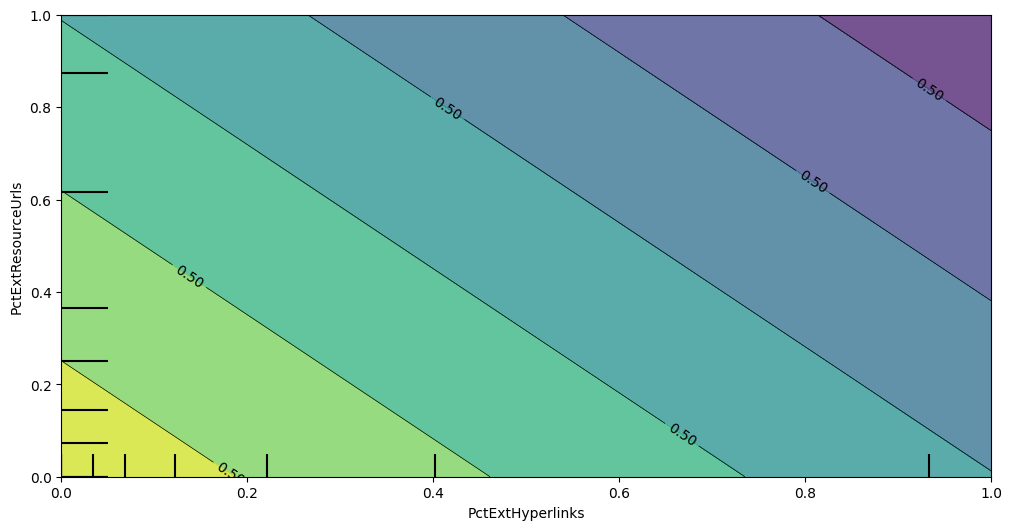

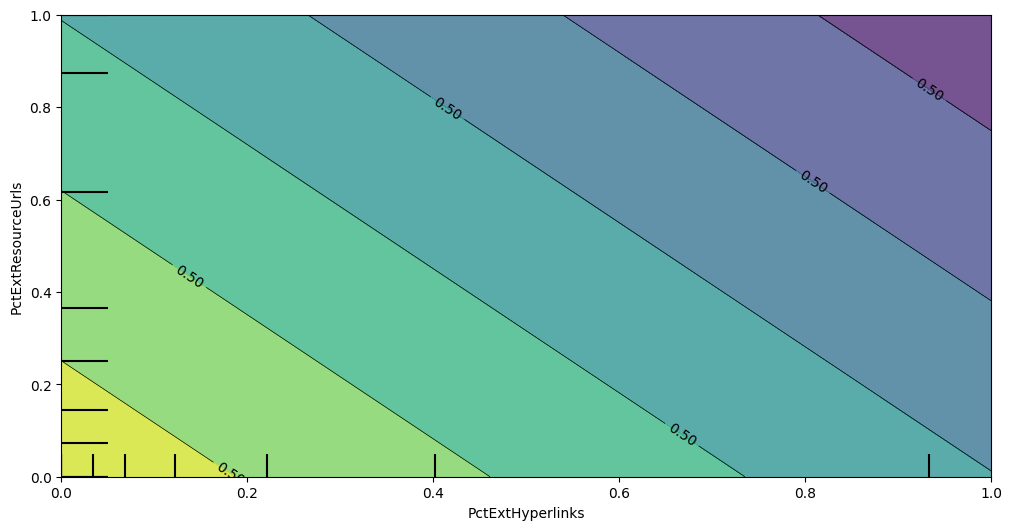

In [ ]:
# Select the top 2 most important features
top_features = mi_scores.head(2).index.tolist()

# Fit the AdaBoost classifier (you already have this part)
adaboost_clf.fit(X_train, y_train)

# Create a PartialDependenceDisplay object
pdp_display = PartialDependenceDisplay.from_estimator(
    adaboost_clf, X_train.sample(1000, random_state=42), features=[(top_features[0], top_features[1])], kind="average"
)

# Plot the partial dependence plots
fig, ax = plt.subplots(figsize=(12, 6))
pdp_display.plot(ax=ax)
plt.show()